<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 2
<br>
<b>Deadline:</b> March 17, 2021 (Wednesday) 23:00
</div>

# Exercise 3.1. Convolutional neural networks. LeNet-5.

In this exercise, you will train a very simple convolutional neural network used for image classification tasks.

If you are not fluent with PyTorch, you may find it useful to look at this tutorial:
* [Neural Networks](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py)

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tools
import tests

In [4]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

The data directory is /coursedata


In [5]:
# Select the device for training (use GPU if you have one)
#device = torch.device('cuda:0')
device = torch.device('cpu')

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## FashionMNIST dataset

Let us use the FashionMNIST dataset. It consists of 60,000 training images of 10 classes: 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'.

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Transform to tensor
    transforms.Normalize((0.5,), (0.5,))  # Scale images to [-1, 1]
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, download=True, transform=transform)

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
           'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=5, shuffle=False)

Let us visualize the data.

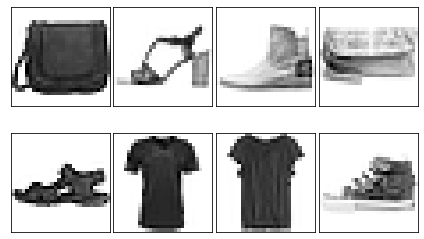

In [8]:
images, labels = iter(trainloader).next()
tests.plot_images(images[:8], n_rows=2)

# 1. Simple convolutional network

In the first exercise, your task is to create a convolutional neural network with the architecture inspired by the classical LeNet-5 [(LeCun et al., 1998)](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

The architecture of the convolutional network that you need to create:
* 2d convolutional layer with:
    * one input channel
    * 6 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* 2d convolutional layer with:
    * 16 output channels
    * kernel size 5 (no padding)
    * followed by ReLU
* Max-pooling layer with kernel size 2 and stride 2
* A fully-connected layer with:
    * 120 outputs
    * followed by ReLU
* A fully-connected layer with:
    * 84 outputs
    * followed by ReLU
* A fully-connected layer with 10 outputs and without nonlinearity.

In [9]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # YOUR CODE HERE
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.mp1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.mp2 = nn.MaxPool2d(2, stride=2)
        self.fc1 = nn.Linear(16*4*4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        #raise NotImplementedError()

    def forward(self, x):
        """
        Args:
          x of shape (batch_size, 1, 28, 28): Input images.
        
        Returns:
          y of shape (batch_size, 10): Outputs of the network.
        """
        # YOUR CODE HERE
        
        y = F.relu(self.conv1(x))
        y = self.mp1(y)
        y = F.relu(self.conv2(y))
        y = self.mp2(y)
        y = y.view(-1, self.num_flat_features(y))
        y = F.relu(self.fc1(y))
        y = F.relu(self.fc2(y))
        y = self.fc3(y)
        return y
        #raise NotImplementedError()
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [10]:
def test_LeNet5_shapes():
    net = LeNet5()

    # Feed a batch of images from the training data to test the network
    with torch.no_grad():
        images, labels = iter(trainloader).next()
        print('Shape of the input tensor:', images.shape)

        y = net(images)
        assert y.shape == torch.Size([trainloader.batch_size, 10]), "Bad shape of y: y.shape={}".format(y.shape)

    print('Success')

test_LeNet5_shapes()

Shape of the input tensor: torch.Size([32, 1, 28, 28])
Success


In [11]:
tests.test_LeNet5(LeNet5)

y: tensor([[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -1.0000, -1.0000, -1.0000,
         -1.0000, -1.0000]], grad_fn=<AddmmBackward>)
expected: tensor([ 1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.])
Success


# Train the network

In [12]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

### Training loop

Your task is to implement the training loop. The recommended hyperparameters:
* Stochastic Gradient Descent (SGD) optimizer with learning rate 0.001 and momentum 0.9.
* Cross-entropy loss. Note that we did not use softmax nonlinearity in the final layer of our network. Therefore, we need to use a loss function with log_softmax implemented, such as [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss).
* Number of epochs: 10. Please use mini-batches produces by `trainloader` defined above.

We recommend you to use function `compute_accuracy()` defined above to track the accuracy during training. The test accuracy should be above 0.87.

In [13]:
# Create network
net = LeNet5()

In [14]:
# Implement the training loop in this cell
if not skip_training:
    # YOUR CODE HERE
    net.zero_grad()
    lossFunc = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    N = 10
    for _ in range(N):
        net.train()
        for images, labels in trainloader:
            optimizer.zero_grad()
            y = net(images)
            loss = lossFunc(y, labels)
            loss.backward()
            optimizer.step()
        
        accuracy = compute_accuracy(net,testloader)
        print(accuracy)
    #raise NotImplementedError()

In [15]:
# Save the model to disk (the pth-files will be submitted automatically together with your notebook)
# Set confirm=False if you do not want to be asked for confirmation before saving.
if not skip_training:
    tools.save_model(net, '1_lenet5.pth', confirm=True)

In [16]:
if skip_training:
    net = LeNet5()
    tools.load_model(net, '1_lenet5.pth', device)

Model loaded from 1_lenet5.pth.


Ground truth labels:  Ankle boot   Pullover    Trouser    Trouser      Shirt
Predictions:          Ankle boot   Pullover    Trouser    Trouser      Shirt


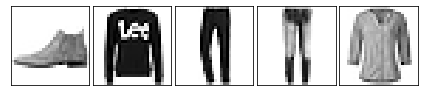

In [17]:
# Display random images from the test set, the ground truth labels and the network's predictions
net.eval()
with torch.no_grad():
    images, labels = iter(testloader).next()
    tests.plot_images(images[:5], n_rows=1)
    
    # Compute predictions
    images = images.to(device)
    y = net(images)

print('Ground truth labels: ', ' '.join('%10s' % classes[labels[j]] for j in range(5)))
print('Predictions:         ', ' '.join('%10s' % classes[j] for j in y.argmax(dim=1)))

In [18]:
# Compute the accuracy on the test set
accuracy = compute_accuracy(net, testloader)
print('Accuracy of the network on the test images: %.3f' % accuracy)
assert accuracy > 0.85, "Poor accuracy {:.3f}".format(accuracy)
print('Success')

Accuracy of the network on the test images: 0.879
Success
